In [1]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Lambda
from keras.layers import LSTM, Embedding, Bidirectional, BatchNormalization, SimpleRNN, Input, TimeDistributed
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
tf.config.list_physical_devices('GPU')

[]

# Base parameters

In [4]:
k = 8                       # number of information bits
N = 16                      # code length

nb_epoch = 2**14 
design = [128, 64, 32]      # each list entry defines the number of nodes in a layer
batch_size = 256            # size of batches for calculation the gradient
LLR = [False, True]         # 'True' enables the log-likelihood-ratio layer
optimizer = 'adam'           
loss = 'mse'                # or 'binary_crossentropy'

train_SNR_Eb = 1            # training-Eb/No
train_SNR_Es = train_SNR_Eb + 10*np.log10(k/N)
train_sigma = np.sqrt(1/(2*10**(train_SNR_Es/10))).tolist()

# Define NN model

In [5]:
def modulateBPSK(x):
    return -2*x +1;

def addNoise(x, sigma):
    w = K.random_normal(K.shape(x), mean=0.0, stddev=sigma)        # std was changed to stddev 
    return x + w

def ber(y_true, y_pred):
    return K.mean(K.not_equal(y_true, K.round(y_pred)))    

def return_output_shape(input_shape):  
    return input_shape

def compose_model(layers):
    model = Sequential()
    for layer in layers:
        model.add(layer)
    return model

def log_likelihood_ratio(x, sigma):   
    return 2*x/np.float32(sigma**2)

def errors(y_true, y_pred):
    return K.sum(int(K.not_equal(y_true, K.round(y_pred))))

# Data Generation

In [6]:
def half_adder(a,b):
    s = a ^ b
    c = a & b
    return s,c

def full_adder(a,b,c):
    s = (a ^ b) ^ c
    c = (a & b) | (c & (a ^ b))
    return s,c

def add_bool(a,b):
    if len(a) != len(b):
        raise ValueError('arrays with different length')
    k = len(a)
    s = np.zeros(k,dtype=bool)
    c = False
    for i in reversed(range(0,k)):
        s[i], c = full_adder(a[i],b[i],c)    
    if c:
        warnings.warn("Addition overflow!")
    return s

def inc_bool(a):
    k = len(a)
    increment = np.hstack((np.zeros(k-1,dtype=bool), np.ones(1,dtype=bool)))
    a = add_bool(a,increment)
    return a

def bitrevorder(x):
    m = np.amax(x)
    n = np.ceil(np.log2(m)).astype(int)
    for i in range(0,len(x)):
        x[i] = int('{:0{n}b}'.format(x[i],n=n)[::-1],2)  
    return x

def int2bin(x,N):
    if isinstance(x, list) or isinstance(x, np.ndarray):
        binary = np.zeros((len(x),N),dtype='bool')
        for i in range(0,len(x)):
            binary[i] = np.array([int(j) for j in bin(x[i])[2:].zfill(N)])
    else:
        binary = np.array([int(j) for j in bin(x)[2:].zfill(N)],dtype=bool)
    
    return binary

def bin2int(b):
    if isinstance(b[0], list):
        integer = np.zeros((len(b),),dtype=int)
        for i in range(0,len(b)):
            out = 0
            for bit in b[i]:
                out = (out << 1) | bit
            integer[i] = out
    elif isinstance(b, np.ndarray):
        if len(b.shape) == 1:
            out = 0
            for bit in b:
                out = (out << 1) | bit
            integer = out     
        else:
            integer = np.zeros((b.shape[0],),dtype=int)
            for i in range(0,b.shape[0]):
                out = 0
                for bit in b[i]:
                    out = (out << 1) | bit
                integer[i] = out
        
    return integer

def polar_design_awgn(N, k, design_snr_dB):  
        
    S = 10**(design_snr_dB/10)
    z0 = np.zeros(N)

    z0[0] = np.exp(-S)
    for j in range(1,int(np.log2(N))+1):
        u = 2**j
        for t in range(0,int(u/2)):
            T = z0[t]
            z0[t] = 2*T - T**2     # upper channel
            z0[int(u/2)+t] = T**2  # lower channel
        
    # sort into increasing order
    idx = np.argsort(z0)
        
    # select k best channels
    idx = np.sort(bitrevorder(idx[0:k]))
    
    A = np.zeros(N, dtype=bool)
    A[idx] = True
        
    return A

def polar_transform_iter(u):

    N = len(u)
    n = 1
    x = np.copy(u)
    stages = np.log2(N).astype(int)
    for s in range(0,stages):
        i = 0
        while i < N:
            for j in range(0,n):
                idx = i+j
                x[idx] = x[idx] ^ x[idx+n]
            i=i+2*n
        n=2*n
    return x

In [7]:
def create_words(code):
    # Create all possible information words
    d = np.zeros((2**k,k),dtype=bool)
    for i in range(1,2**k):
        d[i]= inc_bool(d[i-1])

    # Create sets of all possible codewords (codebook)
    if code == 'polar':   

        A = polar_design_awgn(N, k, design_snr_dB=0)  # logical vector indicating the nonfrozen bit locations 
        x = np.zeros((2**k, N),dtype=bool)
        u = np.zeros((2**k, N),dtype=bool)
        u[:,A] = d

        for i in range(0,2**k):
            x[i] = polar_transform_iter(u[i])
        return x, d, A

    elif code == 'random':

        np.random.seed(4267)   # for a 16bit Random Code (r=0.5) with Hamming distance >= 2
        x = np.random.randint(0,2,size=(2**k,N), dtype=bool)
        return x, d

# Define best train SNR

In [8]:
def update_model(LLR_layer):
    # Define modulator
    modulator_layers = [Lambda(modulateBPSK, 
                              input_shape=(N,), output_shape=return_output_shape, name="modulator")]
    modulator = compose_model(modulator_layers)
    modulator.compile(optimizer=optimizer, loss=loss)

    # Define noise
    noise_layers = [Lambda(addNoise, arguments={'sigma':train_sigma}, 
                           input_shape=(N,), output_shape=return_output_shape, name="noise")]
    noise = compose_model(noise_layers)
    noise.compile(optimizer=optimizer, loss=loss)

    # Define LLR
    llr_layers = [Lambda(log_likelihood_ratio, arguments={'sigma':train_sigma}, 
                         input_shape=(N,), output_shape=return_output_shape, name="LLR")]
    llr = compose_model(llr_layers)
    llr.compile(optimizer=optimizer, loss=loss)

    # Define decoder 
    decoder_layers = [Dense(design[0], activation='relu', input_shape=(N,))]
    for i in range(1,len(design)):
        decoder_layers.append(Dense(design[i], activation='relu'))
    decoder_layers.append(Dense(k, activation='sigmoid'))
    decoder = compose_model(decoder_layers)
    decoder.compile(optimizer=optimizer, loss=loss, metrics=[errors])

    # Define model
    if LLR_layer:
        model_layers = modulator_layers + noise_layers + llr_layers + decoder_layers
    else:
        model_layers = modulator_layers + noise_layers + decoder_layers
    model = compose_model(model_layers)
    model.compile(optimizer=optimizer, loss=loss, metrics=[ber])
    return model, decoder

## Polar codes

In [9]:
code = 'polar'              # type of code ('random' or 'polar')
codewords, inputs, log_vector = create_words(code)

### Train and test model

In [12]:
test_batch = 10000  
num_words = 1000000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))
sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros((len(LLR),len(sigmas)),dtype=int)
nb_bits = np.zeros((len(LLR),len(sigmas)),dtype=int)

In [9]:
%%time
for LLR_layer in LLR:
    model, decoder = update_model(LLR_layer)
    
    print(f'fit {LLR.index(LLR_layer)+1} of {len(LLR)}')
    history = model.fit(codewords, inputs, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)


    print(f'decode {LLR.index(LLR_layer)+1} of {len(LLR)}')
    for i in range(0,len(sigmas)):

        for ii in range(0,np.round(num_words/test_batch).astype(int)):

            # Source
            np.random.seed(0)
            d_test = np.random.randint(0,2,size=(test_batch,k)) 

            # Encoder
            if code == 'polar':
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,log_vector] = d_test

                for iii in range(0,test_batch):
                    x_test[iii] = polar_transform_iter(u_test[iii])

            elif code == 'random':
                x_test = np.zeros((test_batch, N),dtype=bool)
                for iii in range(0,test_batch):
                    x_test[iii] = x[bin2int(d_test[iii])]

            # Modulator (BPSK)
            s_test = -2*x_test + 1

            # Channel (AWGN)
            y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

            if LLR:
                y_test = 2*y_test/(sigmas[i]**2)

            # Decoder
            nb_bits[LLR.index(LLR_layer)][i] += d_test.size
            nb_errors[LLR.index(LLR_layer)][i] += decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
    
            np.savetxt(f'eval_LLR_layer/{code}/bits_{code}_{N}_{k}_{LLR}.out', nb_bits, delimiter=', ')
            np.savetxt(f'eval_LLR_layer/{code}/errors_{code}_{N}_{k}_{LLR}.out', nb_errors, delimiter=', ')

fit 1 of 2
decode 1 of 2
fit 2 of 2
decode 2 of 2
CPU times: user 19min 41s, sys: 39.8 s, total: 20min 21s
Wall time: 21min 47s


### Load data

In [13]:
result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

nb_bits = np.loadtxt(f'eval_LLR_layer/{code}/bits_{code}_{N}_{k}_{LLR}.out', delimiter=', ' )
nb_errors = np.loadtxt(f'eval_LLR_layer/{code}/errors_{code}_{N}_{k}_{LLR}.out', delimiter=', ' )

### Plot Bit-Error-Rate

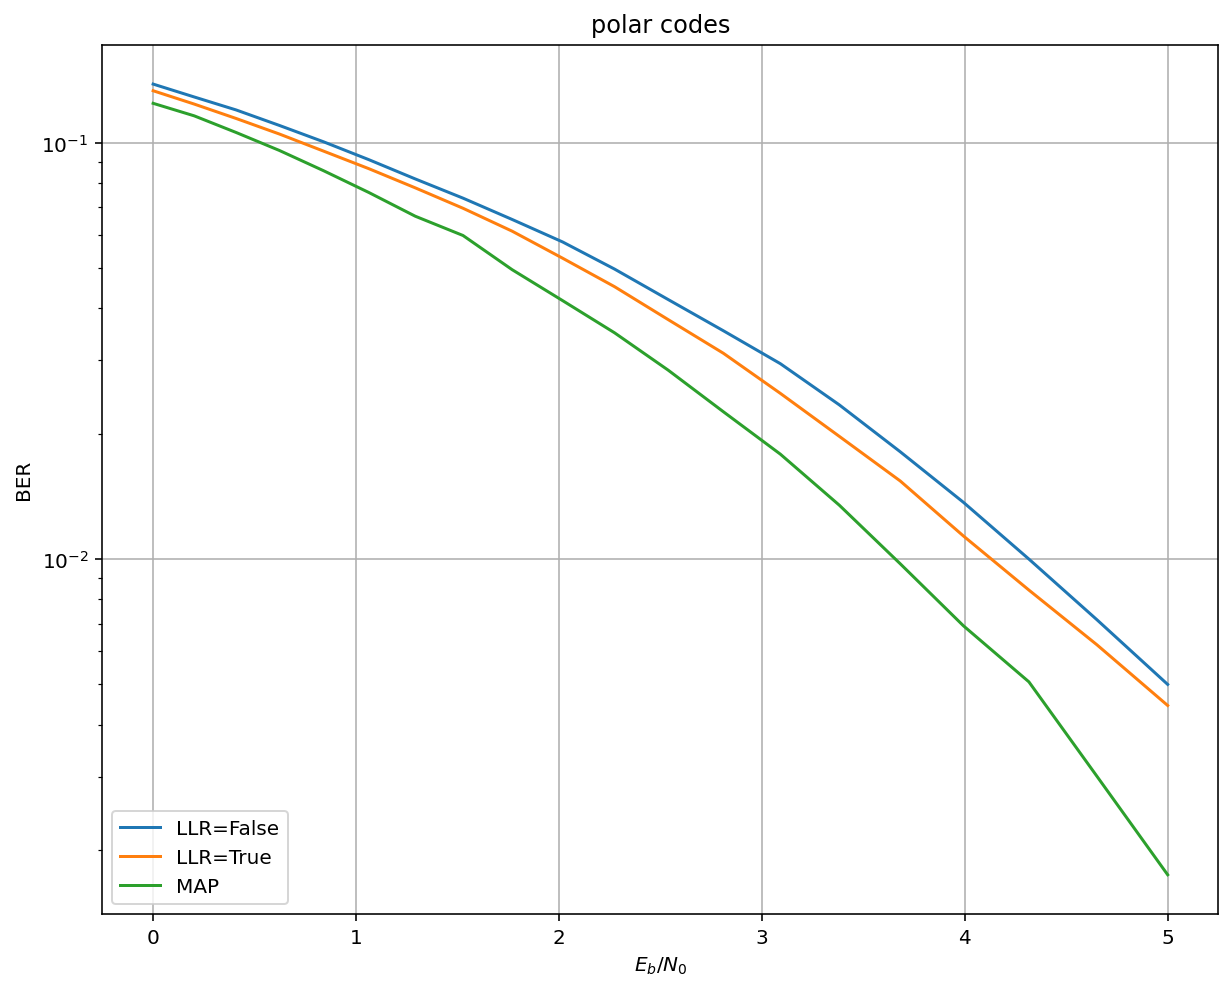

In [14]:
legend = []
plt.figure(figsize=(10, 8))
for LLR_layer in LLR:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors[LLR.index(LLR_layer)]/nb_bits[LLR.index(LLR_layer)])
    legend.append(f'LLR={LLR_layer}') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

## Random codes

In [15]:
code = 'random'              # type of code ('random' or 'polar')
codewords, inputs = create_words(code)

### Train and test model

In [16]:
test_batch = 10000  
num_words = 1000000      # multiple of test_batch

SNR_dB_start_Eb = 0
SNR_dB_stop_Eb = 5
SNR_points = 20

SNR_dB_start_Es = SNR_dB_start_Eb + 10*np.log10(k/N)
SNR_dB_stop_Es = SNR_dB_stop_Eb + 10*np.log10(k/N)

sigma_start = np.sqrt(1/(2*10**(SNR_dB_start_Es/10)))
sigma_stop = np.sqrt(1/(2*10**(SNR_dB_stop_Es/10)))
sigmas = np.linspace(sigma_start, sigma_stop, SNR_points)

nb_errors = np.zeros((len(LLR),len(sigmas)),dtype=int)
nb_bits = np.zeros((len(LLR),len(sigmas)),dtype=int)

In [17]:
%%time
for LLR_layer in LLR:
    model, decoder = update_model(LLR_layer)
    
    print(f'fit {LLR.index(LLR_layer)+1} of {len(LLR)}')
    history = model.fit(codewords, inputs, batch_size=batch_size, epochs=nb_epoch, verbose=0, shuffle=True)


    print(f'decode {LLR.index(LLR_layer)+1} of {len(LLR)}')
    for i in range(0,len(sigmas)):

        for ii in range(0,np.round(num_words/test_batch).astype(int)):

            # Source
            np.random.seed(0)
            d_test = np.random.randint(0,2,size=(test_batch,k)) 

            # Encoder
            if code == 'polar':
                x_test = np.zeros((test_batch, N),dtype=bool)
                u_test = np.zeros((test_batch, N),dtype=bool)
                u_test[:,log_vector] = d_test

                for iii in range(0,test_batch):
                    x_test[iii] = polar_transform_iter(u_test[iii])

            elif code == 'random':
                x_test = np.zeros((test_batch, N),dtype=bool)
                for iii in range(0,test_batch):
                    x_test[iii] = codewords[bin2int(d_test[iii])]

            # Modulator (BPSK)
            s_test = -2*x_test + 1

            # Channel (AWGN)
            y_test = s_test + sigmas[i]*np.random.standard_normal(s_test.shape)

            if LLR:
                y_test = 2*y_test/(sigmas[i]**2)

            # Decoder
            nb_bits[LLR.index(LLR_layer)][i] += d_test.size
            nb_errors[LLR.index(LLR_layer)][i] аа+= decoder.evaluate(y_test, d_test, batch_size=test_batch, verbose=0)[1]
    
            np.savetxt(f'eval_LLR_layer/{code}/bits_{code}_{N}_{k}_{LLR}.out', nb_bits, delimiter=', ')
            np.savetxt(f'eval_LLR_layer/{code}/errors_{code}_{N}_{k}_{LLR}.out', nb_errors, delimiter=', ')

fit 1 of 2
decode 1 of 2
fit 2 of 2
decode 2 of 2
CPU times: user 10min 14s, sys: 36.9 s, total: 10min 51s
Wall time: 11min 9s


### Load data

In [17]:
result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]

nb_bits = np.loadtxt(f'eval_LLR_layer/{code}/bits_{code}_{N}_{k}_{LLR}.out', delimiter=', ' )
nb_errors = np.loadtxt(f'eval_LLR_layer/{code}/errors_{code}_{N}_{k}_{LLR}.out', delimiter=', ' )

### Plot Bit-Error-Rate

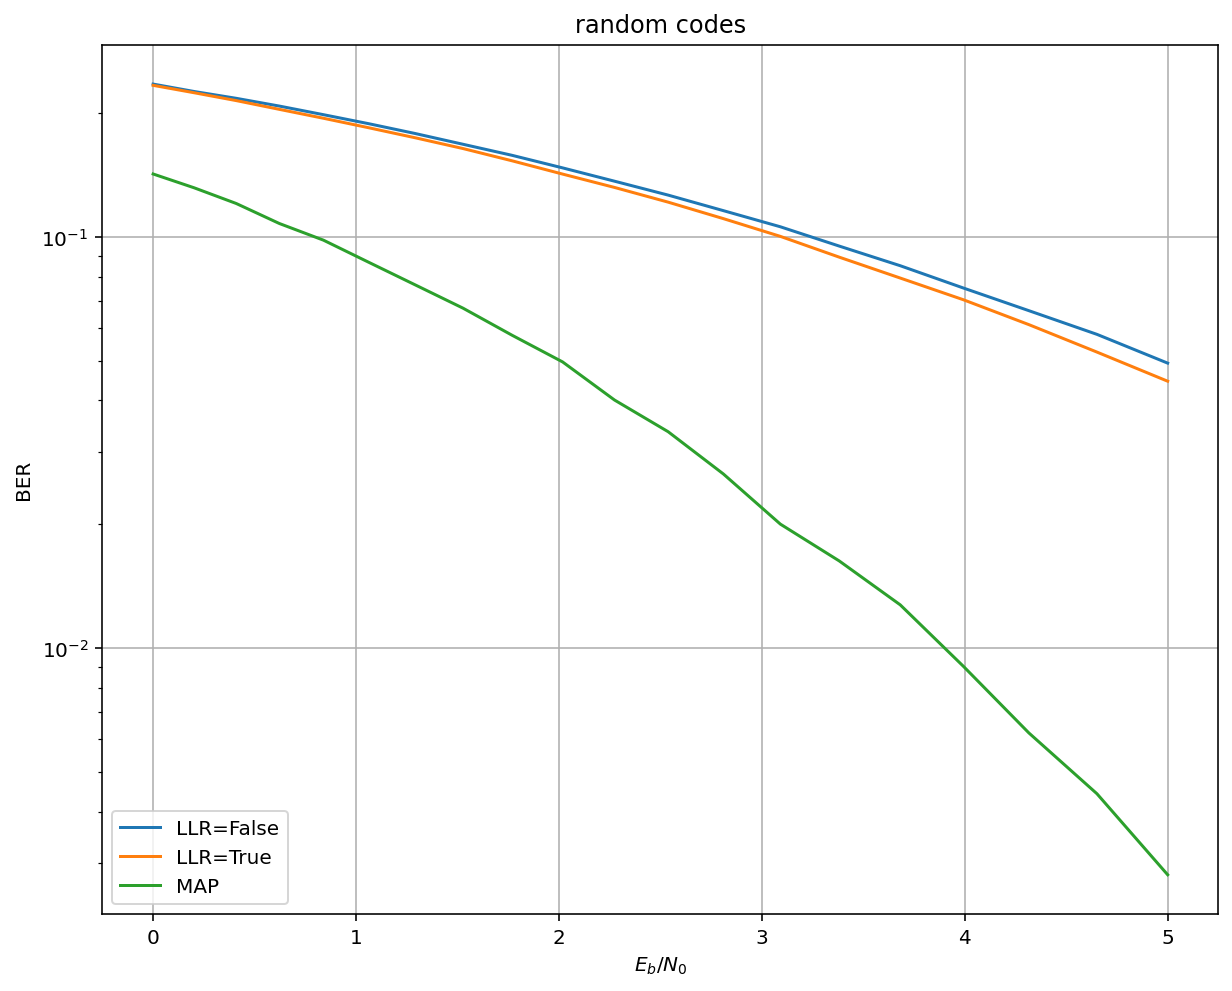

In [19]:
legend = []
plt.figure(figsize=(10, 8))
for LLR_layer in LLR:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors[LLR.index(LLR_layer)]/nb_bits[LLR.index(LLR_layer)])
    legend.append(f'LLR={LLR_layer}') 

plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
plt.title(f'{code} codes')
plt.show()

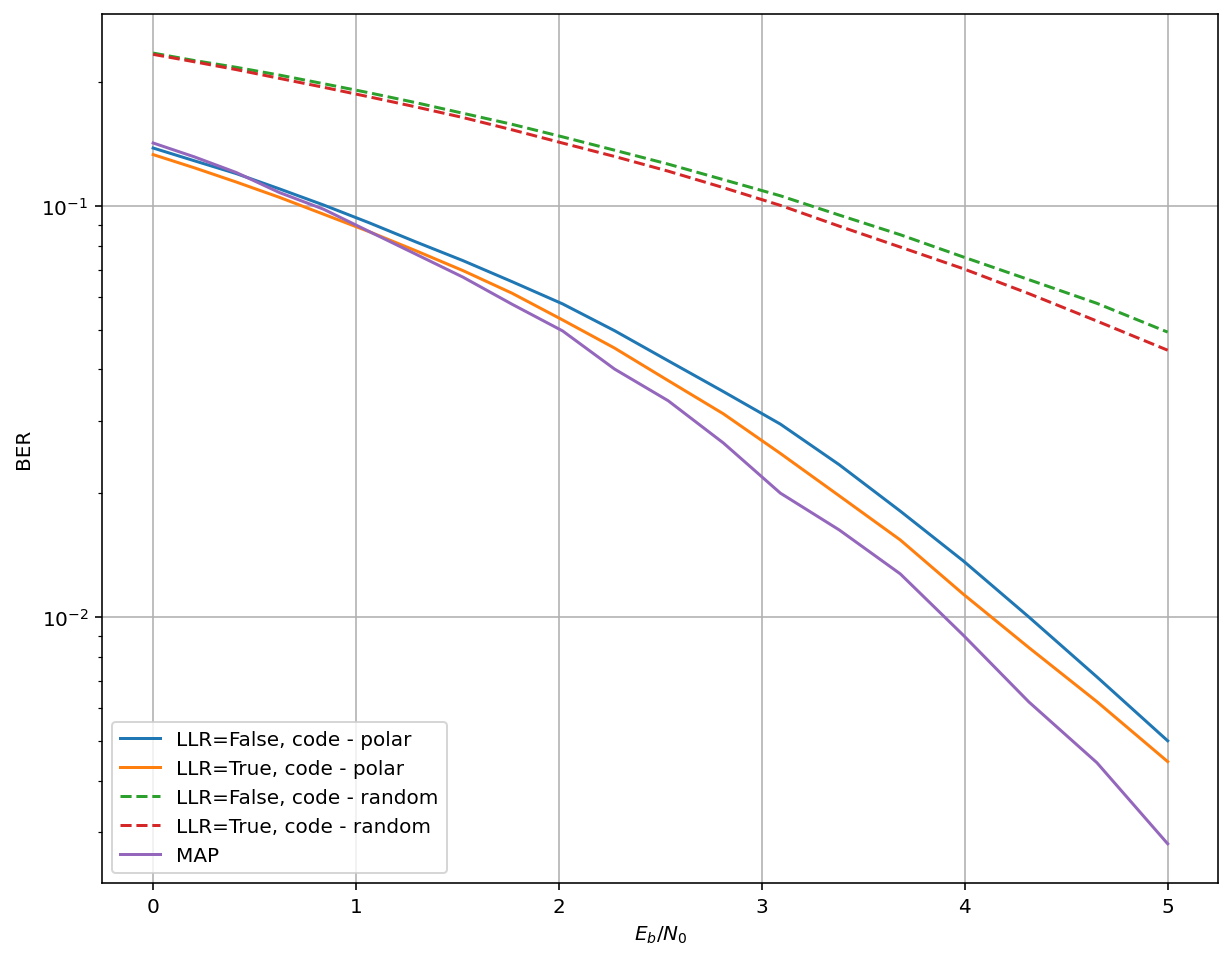

In [20]:
result_map = np.loadtxt('map/{}/results_{}_map_{}_{}.txt'.format(code,code,N,k), delimiter=', ')
sigmas_map = result_map[:,0]
nb_bits_map = result_map[:,1]
nb_errors_map = result_map[:,2]
legend = []
plt.figure(figsize=(10, 8))
code = 'polar'
nb_bits = np.loadtxt(f'eval_LLR_layer/{code}/bits_{code}_{N}_{k}_{LLR}.out', delimiter=', ' )
nb_errors = np.loadtxt(f'eval_LLR_layer/{code}/errors_{code}_{N}_{k}_{LLR}.out', delimiter=', ' )
for LLR_layer in LLR:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors[LLR.index(LLR_layer)]/nb_bits[LLR.index(LLR_layer)])
    legend.append(f'LLR={LLR_layer}, code - {code}') 

code = 'random'
nb_bits = np.loadtxt(f'eval_LLR_layer/{code}/bits_{code}_{N}_{k}_{LLR}.out', delimiter=', ' )
nb_errors = np.loadtxt(f'eval_LLR_layer/{code}/errors_{code}_{N}_{k}_{LLR}.out', delimiter=', ' )
for LLR_layer in LLR:
    plt.plot(10*np.log10(1/(2*sigmas**2)) - 10*np.log10(k/N), nb_errors[LLR.index(LLR_layer)]/nb_bits[LLR.index(LLR_layer)], '--')
    legend.append(f'LLR={LLR_layer}, code - {code}') 
    
plt.plot(10*np.log10(1/(2*sigmas_map**2)) - 10*np.log10(k/N), nb_errors_map/nb_bits_map)
legend.append('MAP')

plt.legend(legend, loc=3)
plt.yscale('log')
plt.xlabel('$E_b/N_0$')
plt.ylabel('BER')    
plt.grid(True)
# plt.title(f'{code} codes')
plt.show()